In [1]:
using DataFrames
using CSV
using StatsPlots
using Distributions
include("../../ThinkBayes.jl/src/ThinkBayes.jl")
using .ThinkBayes

## Test actual Bruins scores 

### Is gamma dist a valid distribution?

In [2]:
# scores downloaded from NHL.com
bruins_scores = DataFrame(CSV.File("../../../Dropbox/org/bruins_scores_2022.csv"));
first(bruins_scores, 6)

,Date,Video,H/R,Dec,O/S,Opp,Record,GF,GA
,String15,String7,String1,String1,String3?,String3,String7,Int64,Int64
1,Apr 19 '22,video,R,W,OT,STL,47-24-5,3,2
2,Apr 16 '22,video,H,W,missing,PIT,46-24-5,2,1
3,Apr 14 '22,video,H,L,missing,OTT,45-24-5,2,3
4,Apr 12 '22,video,H,L,missing,STL,45-23-5,2,4
5,Apr 10 '22,video,R,L,missing,WSH,45-22-5,2,4
6,Apr 08 '22,video,R,W,OT,TBL,45-21-5,2,1


In [3]:
bs_pmf = pmf_from_seq(bruins_scores.GF);

In [4]:
mean(bs_pmf), maximum(bs_pmf)

(3.078947368421052, 8)

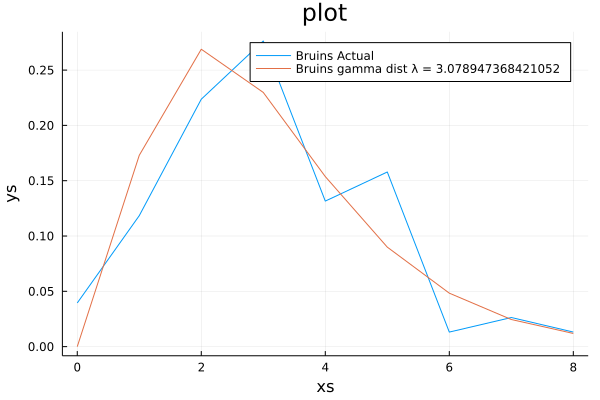

In [5]:
bs_gamma_pmf = make_gamma_pmf(mean(bs_pmf), maximum(bs_pmf), n=9);
plot(bs_pmf, label="Bruins Actual")
plot!(bs_gamma_pmf, label="Bruins gamma dist λ = "*string(mean(bs_pmf)))

_It appears the gamma distribution is pretty close to the actual distribution of goals for the Bruins_

## Test Bruins chances against Carolina given games so far.

In [6]:
bruins_gpg = mean(bs_gamma_pmf)
bruins_max_goals = maximum(bs_gamma_pmf)

8.0

_Now, we'll get the results of games between the Bruins and Carolina_

_we've got Bruins goals against (b_ga_c) and Carolina's goals against (c_ga_b)_

In [20]:
against_car = bruins_scores[bruins_scores.Opp .== "CAR", :]

,Date,Video,H/R,Dec,O/S,Opp,Record,GF,GA
,String15,String7,String1,String1,String3?,String3,String7,Int64,Int64
1,Feb 10 '22,video,H,L,missing,CAR,26-16-3,0,6
2,Jan 18 '22,video,H,L,missing,CAR,22-12-2,1,7
3,Oct 28 '21,video,R,L,missing,CAR,3-3-0,0,3


In [22]:
b_ga_c = against_car.GF
c_ga_b = against_car.GA;

In [23]:
car_gpg = 256 / 77   # hand entered from NHL.com

3.324675324675325

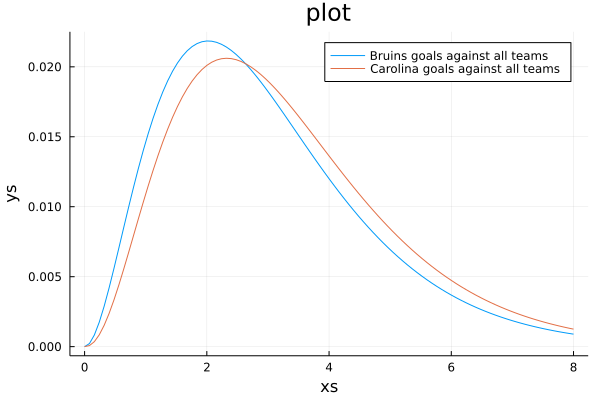

In [24]:
bruins_prior = make_gamma_pmf(bruins_gpg, bruins_max_goals);
car_prior = make_gamma_pmf(car_gpg, bruins_max_goals) # didn't feel like getting Carolina's
plot(bruins_prior, label="Bruins goals against all teams")
plot!(car_prior, label="Carolina goals against all teams")


_Hey, that doesn't look so bad to compare Bruins results against other teams to Carolina's results against other teams!_

_Now, let's look at the head to head matchups_

In [11]:
bruins = copy(bruins_prior)
for d in b_ga_c
    bruins = update_poisson(bruins, d)
end
mean(bruins)

1.005303105247329

In [12]:
car = copy(car_prior)
for d in c_ga_b
    car = update_poisson(car, d)
end
mean(car)

4.809153929635618

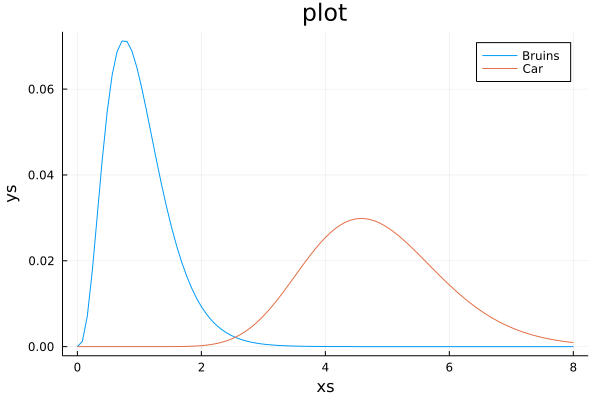

In [13]:
plot(bruins, label="Bruins")
plot!(car, label="Car")

_Well, that doesn't look too good does it?_

In [14]:
goals = [x for x in 0:8]
pmf_seq = [make_poisson_pmf(λ, goals) for λ in values(bruins)];

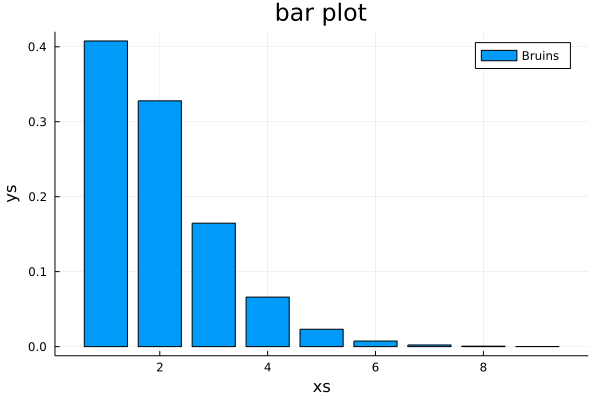

In [15]:
pred_bruins = make_mixture(bruins, pmf_seq)
bar(pred_bruins, label="Bruins")

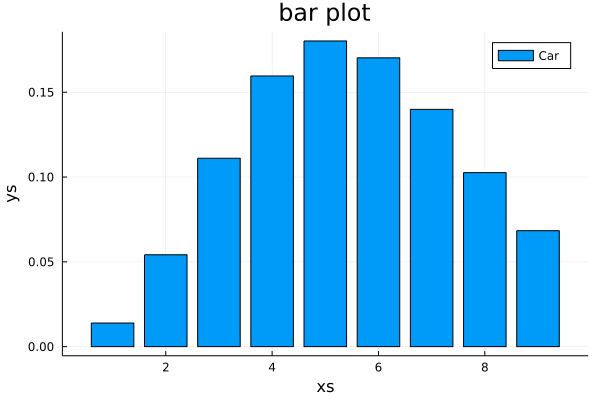

In [16]:
pred_car = make_mixture(car, pmf_seq)
bar(pred_car, label="Car")

In [17]:
win = prob_gt(pred_bruins, pred_car)
lose = prob_lt(pred_bruins, pred_car)
tie = prob_eq(pred_bruins, pred_car)
win, lose, tie

(0.041565638977611036, 0.9003396512966824, 0.05809470972570663)

_Assuming the Bruins win half their ties, their probability of winning against Carolina, given prior results are about 7%_

In [18]:
win + tie/2

0.07061299384046435

_Looks pretty grim getting past the first round assuming Carolina is the opponent :(_

But, there might still be some hope. In games since the two teams last played in February, the Bruins have been 21-8-2 vs Carolina's 17-10-5.
